In [ ]:
c

Mounted at /content/drive


In [ ]:
import numpy as np

images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


In [ ]:
data = np.column_stack((images, masks, labels))
data.shape

(3064, 3)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.08, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.12, random_state=42)

print("Train:", train_data.shape,
      "\nVal:", val_data.shape,
      "\nTest:", test_data.shape,)

Train: (2479, 3) 
Val: (246, 3) 
Test: (339, 3)


In [ ]:
import cv2

def data_to_viz(data, label, n=5):

    # logical slice for receiving data with the expected label
    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]

    # n random samples
    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]

    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:

        # img
        imgs.append(cv2.resize(data_i[0], (512, 512)))

        # mask
        masks.append(cv2.resize(data_i[1].astype("uint8"),
                                (512, 512)))

        # label
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

In [ ]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


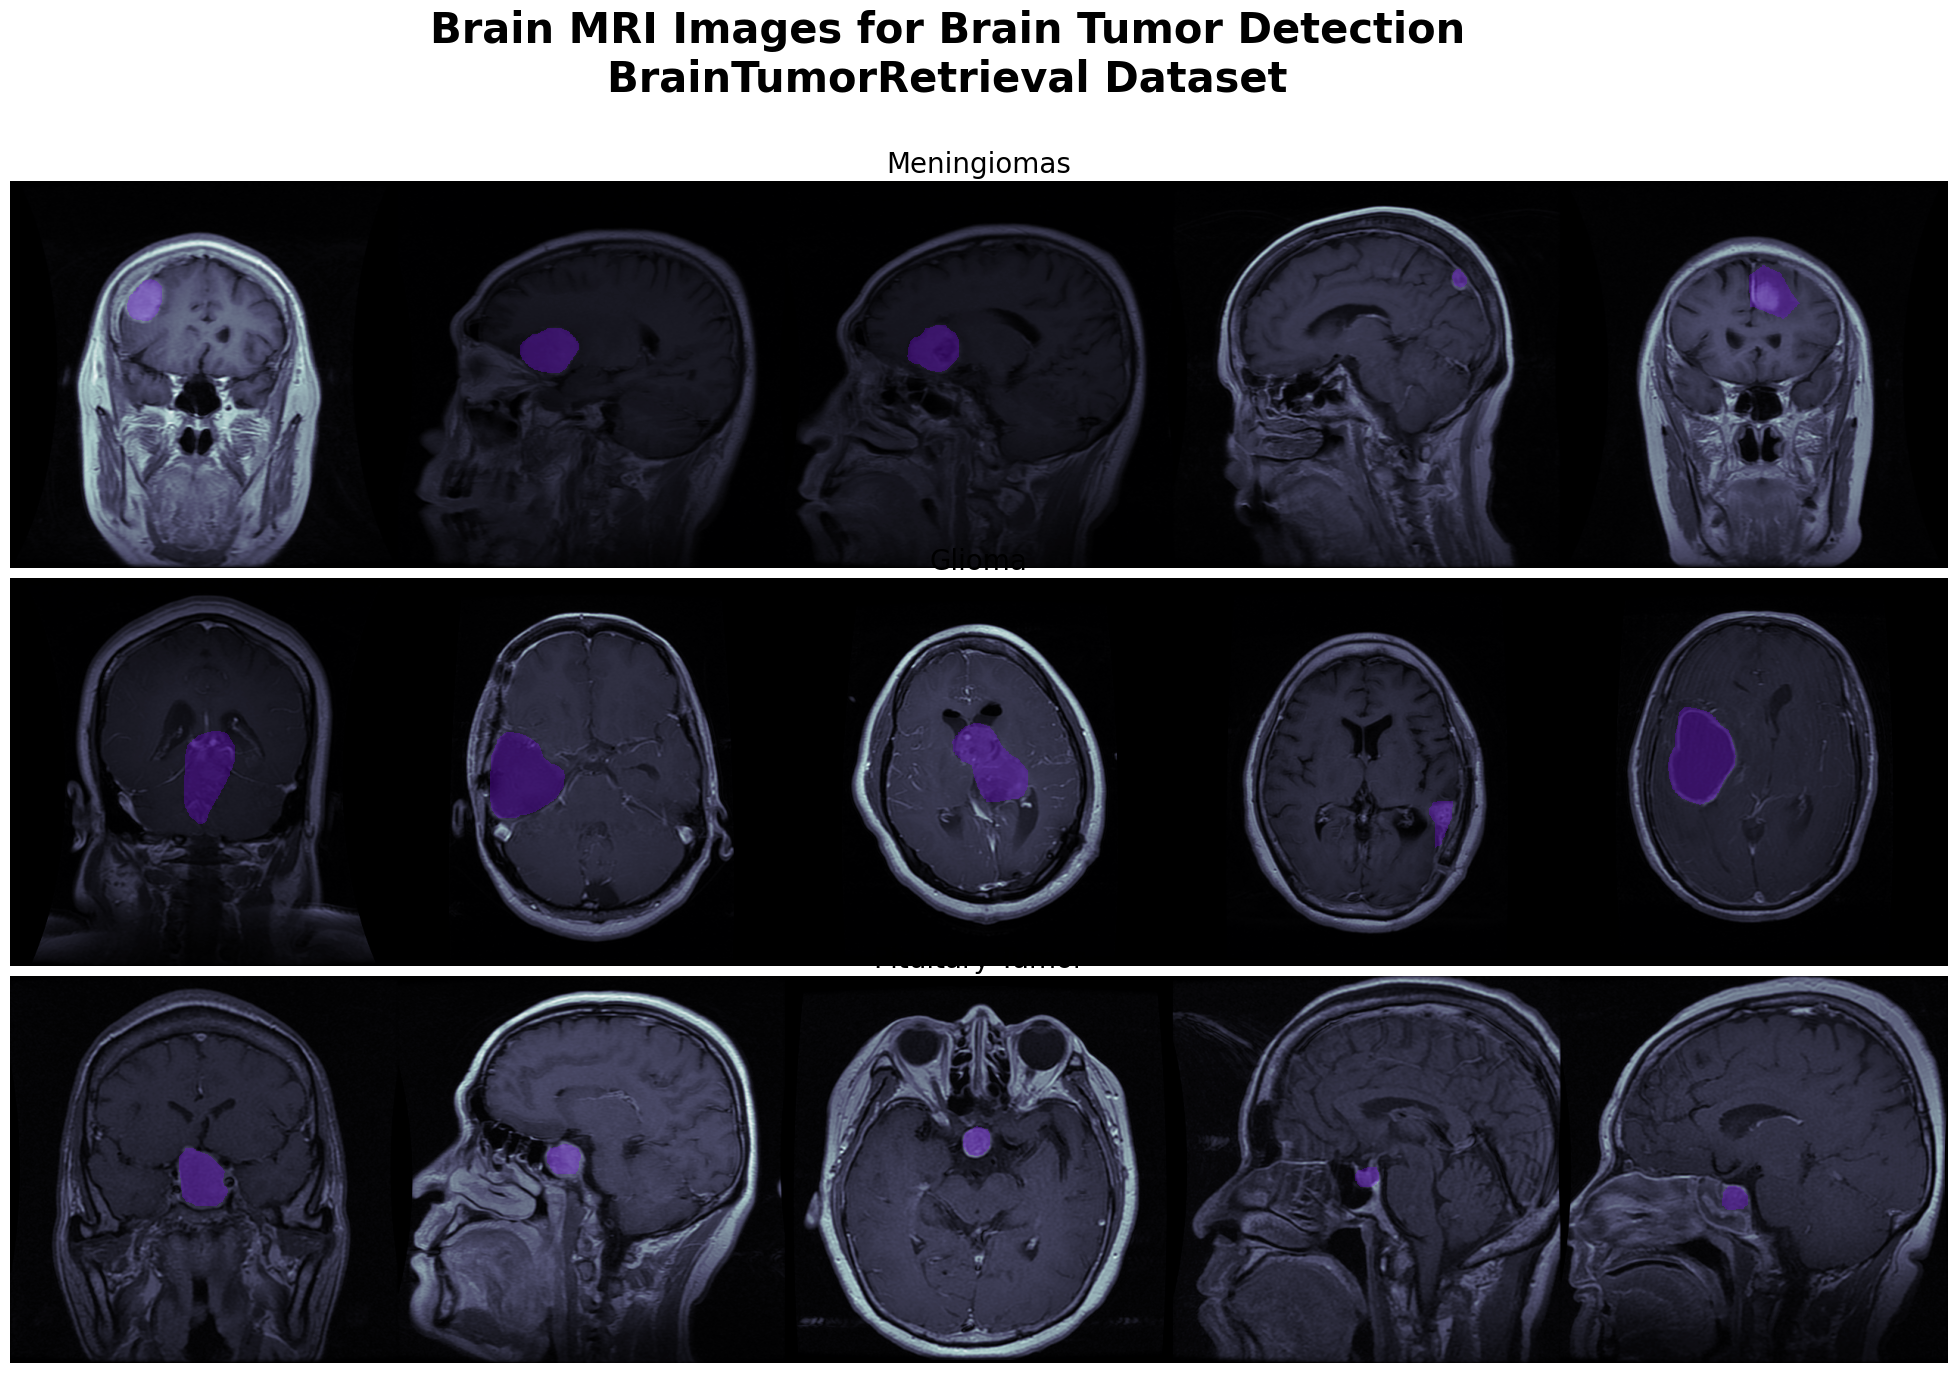

In [ ]:
import matplotlib.pyplot as plt
# Data to visualization
from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False,
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):

        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image = self.data[idx][0].astype("float32")

        # global standardization of pixels
        mean, std = image.mean(), image.std()
        image = (image - mean) / std

        # convert to rgb
        image_rgb = np.stack([image]*3).transpose(1,2,0)

        # create target masks
        label = self.data[idx][2] -1
        mask = np.expand_dims(self.data[idx][1], -1)

        target_mask = np.zeros((mask.shape[0], mask.shape[1],
                                self.n_classes))
        target_mask[:,:, label : label + 1] = mask.astype("uint8")

        #  binary mask
        target_mask = np.clip(target_mask, 0, 1).astype("float32")

        # augmentations
        augmented = self.transforms(image=image_rgb,
                                    mask=target_mask)
        image = augmented['image']
        mask = augmented['mask']

        return image, mask

In [ ]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5,
                       border_mode=0),

    A.GridDistortion(p=0.5),
    A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    A.Resize(156, 156, p=1.),
    A.RandomCrop(128, 128, p=1.)
    ])

In [ ]:
# train
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4,
                              shuffle=True)

# validation
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4,
                            shuffle=True)

# test
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4,
                             shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([16, 128, 128, 3]) torch.Size([16, 128, 128, 3])


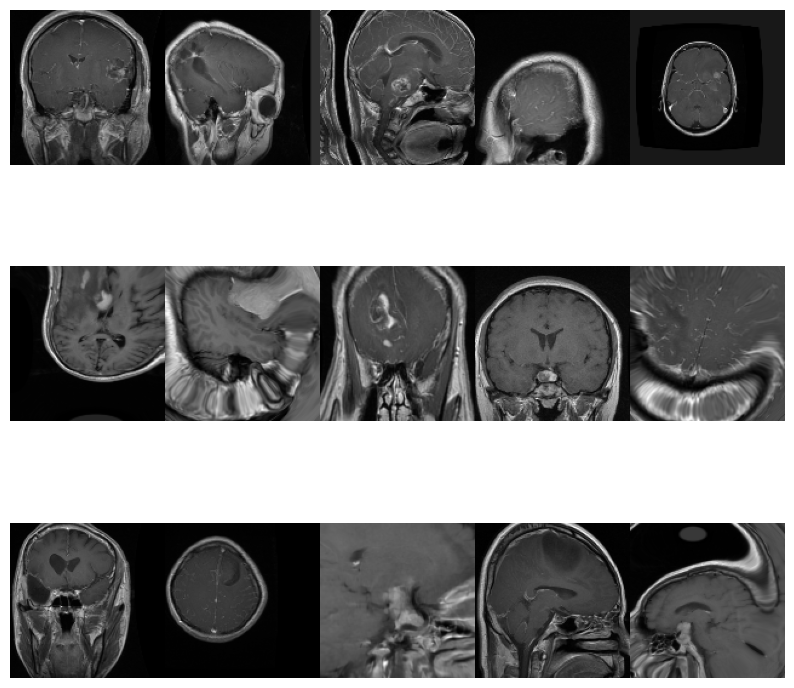

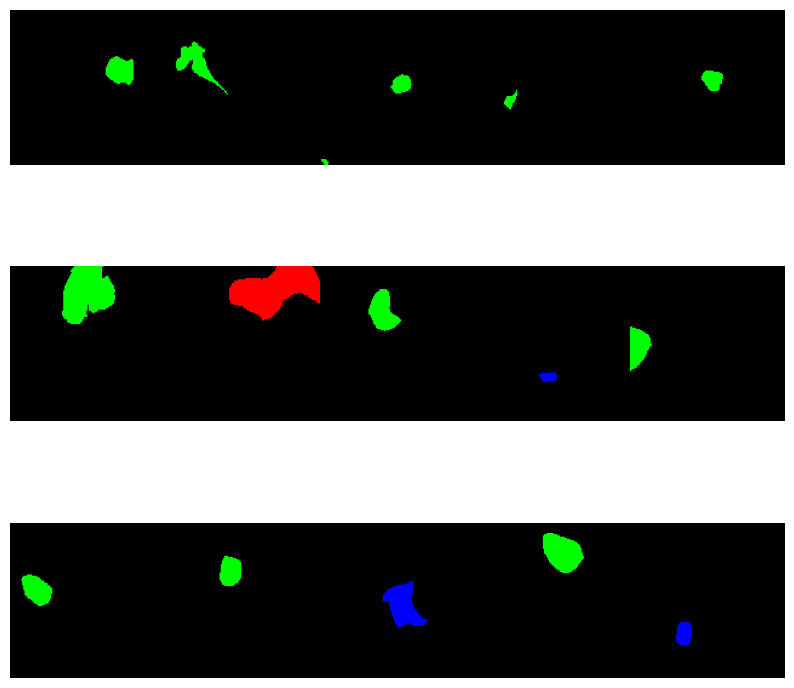

In [ ]:
def show_aug(inputs, nrows=3, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 15:
        inputs = inputs[:15]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy()#.transpose(1,2,0)
            img = (img - img.min()) / (img.max() - img.min())  # normalize to [0, 1]
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]

        #plot
        #print(img.max(), len(np.unique(img)), img.mean())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img);
        plt.axis('off')

        i_ += 1

    return plt.show()

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks)


In [ ]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)

        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)

        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [ ]:
class SegNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)


    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)

        return out

In [ ]:
# Instantiate the SegNet model
model = SegNet(n_classes=3).to(device)
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 88.1MB/s]


In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_coef_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [ ]:
def train_one_epoch(model, optimizer, lr_scheduler, data_loader, epoch):
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in data_loader:

        data = data.permute(0,3,1,2).to(device)
        targets = target.permute(0,3,1,2).to(device)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())

        loss = bce_dice_loss(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if lr_scheduler is not None:
        lr_scheduler.step()

    print("Epoch [%d]" % (epoch))
    print("Mean loss on train:", np.array(losses).mean(), "Mean DICE on train:", np.array(accur).mean())

    return np.array(losses).mean(), np.array(accur).mean()

In [ ]:
def val_epoch(model, data_loader_valid, epoch, threshold=0.3):
    if epoch is None:
        print("Test Start...")
    else:
        print("Start Validation ...")

    model.eval()
    val_acc = []

    with torch.no_grad():
        for data, targets in data_loader_valid:

            data = data.permute(0,3,1,2).to(device)
            targets = targets.permute(0,3,1,2).to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())

        return np.array(val_acc).mean()

In [19]:

from tqdm import trange
import os
import glob

weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)

num_epochs = 30
loss_history = []
train_dice_history = []
val_dice_history = []

for epoch in trange(num_epochs):
    loss, train_dice = train_one_epoch(model, adam, scheduler,
                                       train_dataloader, epoch)

    val_dice = valscore = val_epoch(model, val_dataloader, epoch)

    # train history
    loss_history.append(loss)
    train_dice_history.append(train_dice)
    val_dice_history.append(val_dice)

    # save best weights
    best_dice = max(val_dice_history)
    if val_dice >= best_dice:
        torch.save({'state_dict': model.state_dict()},
                   os.path.join(weights_dir, f"{val_dice:0.5f}_.pth"))

  0%|          | 0/30 [00:00<?, ?it/s]

Start Train ...
Epoch [0]
Mean loss on train: 0.9095141014745158 Mean DICE on train: 0.16191822094251626
Start Validation ...
Epoch:  0  Threshold:  0.3 Mean Validation DICE Score: 0.3182937686346338


  3%|▎         | 1/30 [01:41<48:54, 101.20s/it]

Start Train ...
Epoch [1]
Mean loss on train: 0.666958349750888 Mean DICE on train: 0.4103583127242962
Start Validation ...
Epoch:  1  Threshold:  0.3 Mean Validation DICE Score: 0.48296107961024237


  7%|▋         | 2/30 [03:18<46:03, 98.70s/it] 

Start Train ...
Epoch [2]
Mean loss on train: 0.5660902536684467 Mean DICE on train: 0.5033693842421725
Start Validation ...
Epoch:  2  Threshold:  0.3 Mean Validation DICE Score: 0.51649595283097


 10%|█         | 3/30 [04:54<43:58, 97.73s/it]

Start Train ...
Epoch [3]
Mean loss on train: 0.5270288982698994 Mean DICE on train: 0.5352096007474967
Start Validation ...


 13%|█▎        | 4/30 [06:32<42:17, 97.60s/it]

Epoch:  3  Threshold:  0.3 Mean Validation DICE Score: 0.4288698581022923
Start Train ...
Epoch [4]
Mean loss on train: 0.49664045418462444 Mean DICE on train: 0.5533418980674742
Start Validation ...
Epoch:  4  Threshold:  0.3 Mean Validation DICE Score: 0.5186170479480483


 17%|█▋        | 5/30 [08:09<40:35, 97.43s/it]

Start Train ...
Epoch [5]
Mean loss on train: 0.48153270348425836 Mean DICE on train: 0.56151672595535
Start Validation ...


 20%|██        | 6/30 [09:48<39:12, 98.01s/it]

Epoch:  5  Threshold:  0.3 Mean Validation DICE Score: 0.5180727678060673
Start Train ...
Epoch [6]
Mean loss on train: 0.4312413970308919 Mean DICE on train: 0.622933289499801
Start Validation ...


 23%|██▎       | 7/30 [11:25<37:30, 97.85s/it]

Epoch:  6  Threshold:  0.3 Mean Validation DICE Score: 0.5129428830337684
Start Train ...
Epoch [7]
Mean loss on train: 0.4368444754231361 Mean DICE on train: 0.5980146972737721
Start Validation ...
Epoch:  7  Threshold:  0.3 Mean Validation DICE Score: 0.5559014324673471


 27%|██▋       | 8/30 [13:04<36:00, 98.22s/it]

Start Train ...
Epoch [8]
Mean loss on train: 0.4310503690473495 Mean DICE on train: 0.6143505267201177
Start Validation ...


 30%|███       | 9/30 [14:43<34:25, 98.34s/it]

Epoch:  8  Threshold:  0.3 Mean Validation DICE Score: 0.500852360583484
Start Train ...
Epoch [9]
Mean loss on train: 0.44780738392183855 Mean DICE on train: 0.6069413157000189
Start Validation ...
Epoch:  9  Threshold:  0.3 Mean Validation DICE Score: 0.6236153795303094


 33%|███▎      | 10/30 [16:23<32:53, 98.69s/it]

Start Train ...
Epoch [10]
Mean loss on train: 0.3793825332195528 Mean DICE on train: 0.6636979329633493
Start Validation ...
Epoch:  10  Threshold:  0.3 Mean Validation DICE Score: 0.6750457134566272


 37%|███▋      | 11/30 [18:00<31:08, 98.35s/it]

Start Train ...
Epoch [11]
Mean loss on train: 0.3578137613111927 Mean DICE on train: 0.6768284166948001
Start Validation ...


 40%|████      | 12/30 [19:38<29:26, 98.14s/it]

Epoch:  11  Threshold:  0.3 Mean Validation DICE Score: 0.6667922151983642
Start Train ...
Epoch [12]
Mean loss on train: 0.3390421292474193 Mean DICE on train: 0.6885114332315311
Start Validation ...


 43%|████▎     | 13/30 [21:15<27:45, 97.95s/it]

Epoch:  12  Threshold:  0.3 Mean Validation DICE Score: 0.6747244247860865
Start Train ...
Epoch [13]
Mean loss on train: 0.3336942026692052 Mean DICE on train: 0.6980402408662854
Start Validation ...
Epoch:  13  Threshold:  0.3 Mean Validation DICE Score: 0.6927961397203375


 47%|████▋     | 14/30 [22:53<26:07, 97.98s/it]

Start Train ...
Epoch [14]
Mean loss on train: 0.32734487518187494 Mean DICE on train: 0.6979608002847775
Start Validation ...
Epoch:  14  Threshold:  0.3 Mean Validation DICE Score: 0.7158387910618866


 50%|█████     | 15/30 [24:31<24:29, 97.97s/it]

Start Train ...
Epoch [15]
Mean loss on train: 0.32390563295733543 Mean DICE on train: 0.7019849162276951
Start Validation ...


 53%|█████▎    | 16/30 [26:08<22:48, 97.73s/it]

Epoch:  15  Threshold:  0.3 Mean Validation DICE Score: 0.6894221091791173
Start Train ...
Epoch [16]
Mean loss on train: 0.32046153353106593 Mean DICE on train: 0.7023329825012802
Start Validation ...


 57%|█████▋    | 17/30 [27:45<21:04, 97.26s/it]

Epoch:  16  Threshold:  0.3 Mean Validation DICE Score: 0.6815463171764158
Start Train ...
Epoch [17]
Mean loss on train: 0.31464025541659324 Mean DICE on train: 0.7124297450784944
Start Validation ...


 60%|██████    | 18/30 [29:22<19:26, 97.23s/it]

Epoch:  17  Threshold:  0.3 Mean Validation DICE Score: 0.7144821186591112
Start Train ...
Epoch [18]
Mean loss on train: 0.30393579486877687 Mean DICE on train: 0.7246646350530147
Start Validation ...
Epoch:  18  Threshold:  0.3 Mean Validation DICE Score: 0.7242134195417198


 63%|██████▎   | 19/30 [30:59<17:50, 97.27s/it]

Start Train ...
Epoch [19]
Mean loss on train: 0.2996891843695794 Mean DICE on train: 0.7307711226677406
Start Validation ...


 67%|██████▋   | 20/30 [32:38<16:16, 97.67s/it]

Epoch:  19  Threshold:  0.3 Mean Validation DICE Score: 0.6951965203523784
Start Train ...
Epoch [20]
Mean loss on train: 0.289958062671846 Mean DICE on train: 0.7370104920757637
Start Validation ...


 70%|███████   | 21/30 [34:17<14:43, 98.21s/it]

Epoch:  20  Threshold:  0.3 Mean Validation DICE Score: 0.6954618254506685
Start Train ...
Epoch [21]
Mean loss on train: 0.2965256010332415 Mean DICE on train: 0.7317715981704755
Start Validation ...


 73%|███████▎  | 22/30 [35:55<13:04, 98.04s/it]

Epoch:  21  Threshold:  0.3 Mean Validation DICE Score: 0.6841341043878119
Start Train ...
Epoch [22]
Mean loss on train: 0.29112470962347525 Mean DICE on train: 0.7373502198554749
Start Validation ...


 77%|███████▋  | 23/30 [37:33<11:26, 98.08s/it]

Epoch:  22  Threshold:  0.3 Mean Validation DICE Score: 0.6648350505679246
Start Train ...
Epoch [23]
Mean loss on train: 0.2946492676773379 Mean DICE on train: 0.7269093532171792
Start Validation ...


 80%|████████  | 24/30 [39:10<09:46, 97.76s/it]

Epoch:  23  Threshold:  0.3 Mean Validation DICE Score: 0.7087437231587226
Start Train ...
Epoch [24]
Mean loss on train: 0.2920716735624498 Mean DICE on train: 0.7326352262593461
Start Validation ...


 83%|████████▎ | 25/30 [40:47<08:07, 97.59s/it]

Epoch:  24  Threshold:  0.3 Mean Validation DICE Score: 0.6882100945963496
Start Train ...
Epoch [25]
Mean loss on train: 0.28731329431456903 Mean DICE on train: 0.7406105093205044
Start Validation ...


 87%|████████▋ | 26/30 [42:23<06:28, 97.18s/it]

Epoch:  25  Threshold:  0.3 Mean Validation DICE Score: 0.7069078311663535
Start Train ...
Epoch [26]
Mean loss on train: 0.29195575175746796 Mean DICE on train: 0.7346873097403673
Start Validation ...


 90%|█████████ | 27/30 [44:01<04:51, 97.31s/it]

Epoch:  26  Threshold:  0.3 Mean Validation DICE Score: 0.7170238826542794
Start Train ...
Epoch [27]
Mean loss on train: 0.2866548763648156 Mean DICE on train: 0.7338681390301084
Start Validation ...
Epoch:  27  Threshold:  0.3 Mean Validation DICE Score: 0.731095421124907


 93%|█████████▎| 28/30 [45:39<03:15, 97.55s/it]

Start Train ...
Epoch [28]
Mean loss on train: 0.29531128954502844 Mean DICE on train: 0.7346495262975058
Start Validation ...


 97%|█████████▋| 29/30 [47:18<01:37, 97.99s/it]

Epoch:  28  Threshold:  0.3 Mean Validation DICE Score: 0.7131461900571391
Start Train ...
Epoch [29]
Mean loss on train: 0.29069082611991515 Mean DICE on train: 0.7373283776392869
Start Validation ...


100%|██████████| 30/30 [48:56<00:00, 97.89s/it]

Epoch:  29  Threshold:  0.3 Mean Validation DICE Score: 0.7202540120078778


In [20]:
def plot_model_history(train_history,
                       val_history,
                       loss_history ,
                       num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")
    plt.plot(x, loss_history, label='dice + bce', lw=3)

    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.legend()

    return plt.show()


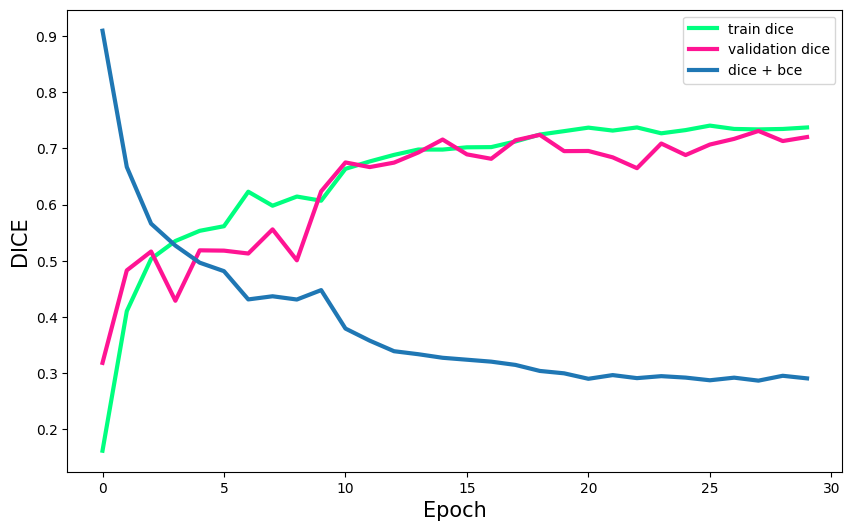

In [23]:
 plot_model_history(train_dice_history, val_dice_history, loss_history, num_epochs)

In [21]:
test_iou = val_epoch(model, test_dataloader, epoch=None, threshold=0.5)
print(f"""Mean IoU of the test images - {np.around(test_iou, 2)*100}%""")

Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.740127985395895
Mean IoU of the test images - 74.0%


In [24]:
dices = []
thresholds = [0.1, 0.2, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.88]
for i in thresholds:
    test_dice = val_epoch(model, test_dataloader,threshold=i, epoch=None)
    dices.append(test_dice)

Test Start...
Epoch:  None  Threshold:  0.1 Mean Validation DICE Score: 0.7470172112780403
Test Start...
Epoch:  None  Threshold:  0.2 Mean Validation DICE Score: 0.7458761319059971
Test Start...
Epoch:  None  Threshold:  0.33 Mean Validation DICE Score: 0.744729884473077
Test Start...
Epoch:  None  Threshold:  0.4 Mean Validation DICE Score: 0.7302707422516977
Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.7062138097479291
Test Start...
Epoch:  None  Threshold:  0.6 Mean Validation DICE Score: 0.7315082452973146
Test Start...
Epoch:  None  Threshold:  0.7 Mean Validation DICE Score: 0.7256843062883435
Test Start...
Epoch:  None  Threshold:  0.8 Mean Validation DICE Score: 0.7320726679969767
Test Start...
Epoch:  None  Threshold:  0.85 Mean Validation DICE Score: 0.7426490670869488
Test Start...
Epoch:  None  Threshold:  0.88 Mean Validation DICE Score: 0.7215273948569568


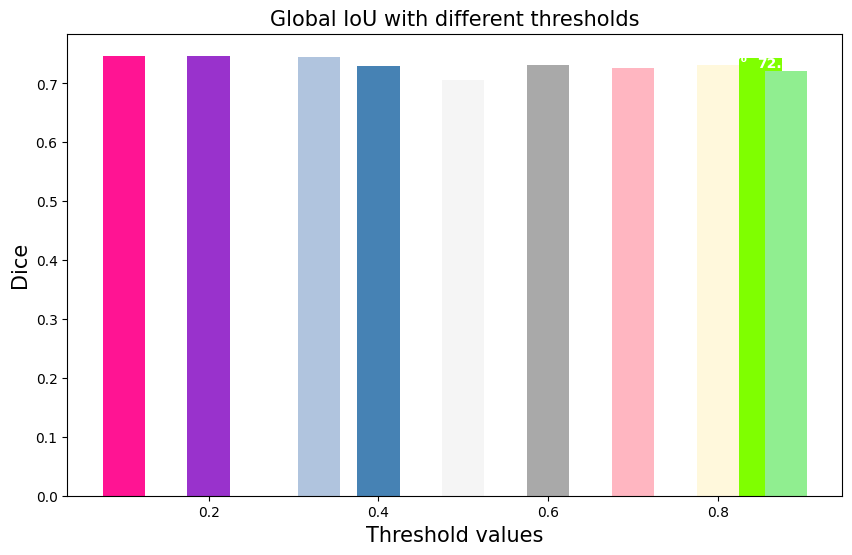

In [32]:
import random
import matplotlib.colors as mcolors

colors = random.choices(list(mcolors.CSS4_COLORS.keys()),k=len(thresholds))

plt.figure(figsize=(10,6))
plt.bar(thresholds, dices, width=0.05, color=colors)
plt.ylabel("Dice", fontsize=15)
plt.xlabel("Threshold values", fontsize=15)
plt.title("Global IoU with different thresholds", fontsize=15)


# Annotate
for row, value in zip(thresholds, dices):
    plt.annotate(f"{value*100:0.2f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")

In [36]:
test_predictions = []
test_ground_truths = []
for data, target in test_dataloader:
    with torch.no_grad():
        data = data.permute(0,3,1,2).to(device)
        target = target.permute(0,3,1,2)
        prediction = model(data)
        test_predictions.append(prediction.detach().cpu())
        test_ground_truths.append(target)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [37]:
test_predictions = torch.cat(test_predictions)
test_ground_truths = torch.cat(test_ground_truths)
#test_predictions = test_predictions.reshape(test_predictions.shape[0], -1)
#test_ground_truths = test_ground_truths.reshape(test_ground_truths.shape[0], -1)

print(test_predictions.shape, test_ground_truths.shape)

torch.Size([339, 3, 128, 128]) torch.Size([339, 3, 128, 128])


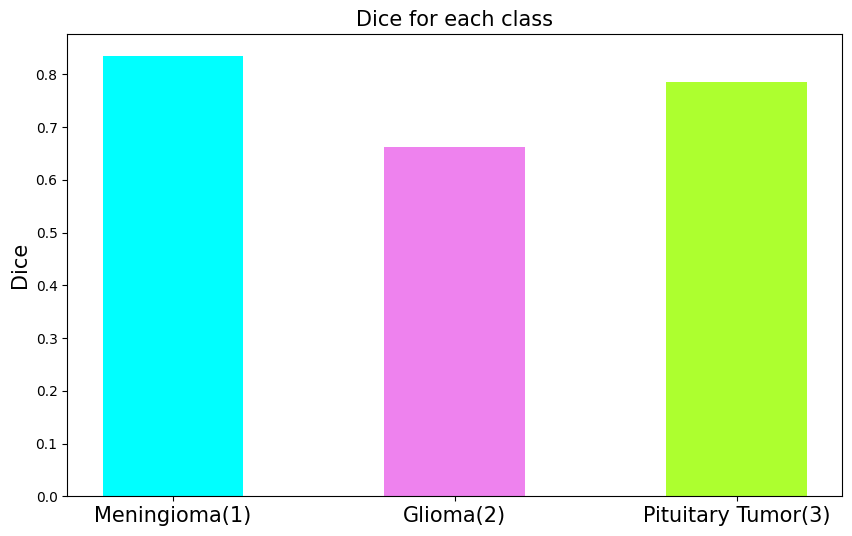

In [38]:
#data
dice1 = dice_coef_metric(test_predictions[:,0,:,:], test_ground_truths[:,0,:,:])
dice2 = dice_coef_metric(test_predictions[:,1,:,:], test_ground_truths[:,1,:,:])
dice3 = dice_coef_metric(test_predictions[:,2,:,:], test_ground_truths[:,2,:,:])
dices = [dice1, dice2, dice3]

# x, y
x = np.arange(3)
dices = [dice1, dice2, dice3]

# plot
plt.figure(figsize=(10, 6))
plt.bar(x, dices,
        color=["aqua", "violet", "greenyellow"], width=0.5)


plt.xticks(x, ['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'], fontsize=15)
plt.ylabel("Dice", fontsize=15)
plt.title("Dice for each class", fontsize=15)


# Annotate
for row, value in zip(x, dices):
    plt.annotate(f"{value*100:0.3f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")

plt.show()

In [39]:
index = np.random.choice(test_data.shape[0], 1, replace=False)
                                                                    
# image
image = test_data[index][0][0]


mean, std = image.mean(), image.std()
image = (image - mean) / std
image = cv2.resize(image, (128, 128))
# convert to rgb
image = np.stack([image]*3).transpose(1,2,0)

# mask
mask = test_data[index][0][1]

# label
label = test_data[index][0][2]

print(image.shape, mask.shape, label)

(128, 128, 3) (512, 512) 1


Text(0.5, 1.0, 'Pituitary tumor')

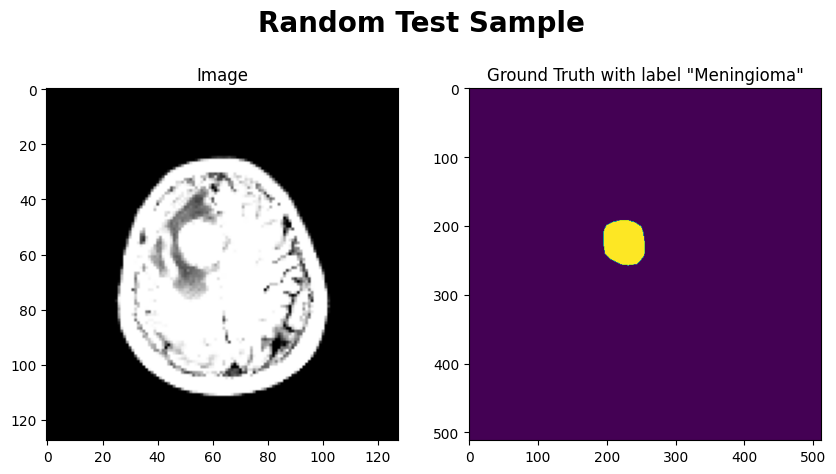

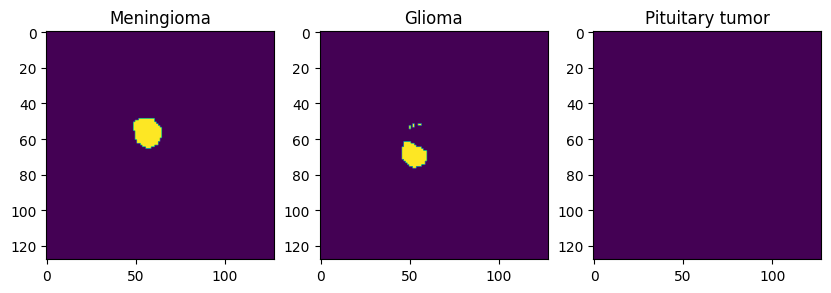

In [40]:
# predictions
preds = torch.tensor(image.astype(np.float32)).unsqueeze(0).permute(0,3,1,2)
preds = model(preds.to(device))
preds = preds.detach().cpu().numpy()

# threshold
preds[np.nonzero(preds < 0.4)] = 0.0
preds[np.nonzero(preds >= 0.4)] = 255.#1.0
preds = preds.astype("uint8")

pred_1 = preds[:,0,:,:]
pred_2 = preds[:,1,:,:]
pred_3 = preds[:,2,:,:]


#------------ Plot ------------#

# data plot
fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(10, 10))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title(f'Ground Truth with label "{integer_to_class[label].capitalize()}"')
#ax[1].imshow(preds[0,:,:,:])
#ax[0].set_title("Preiction")
plt.suptitle("Random Test Sample",
             y=.75, fontsize=20, weight="bold")

# prediction plot
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))

ax[0].imshow(pred_1[0,:,:])
ax[0].set_title(f'{integer_to_class[1].capitalize()}')
ax[1].imshow(pred_2[0,:,:])
ax[1].set_title(f'{integer_to_class[2].capitalize()}')
ax[2].imshow(pred_3[0,:,:])
ax[2].set_title(f'{integer_to_class[3].capitalize()}')